RESULTADOS DEL AJUSTE DE MODELOS

--- MODELO PELEG ---
Parámetros optimizados: [ 2.5752042   0.13453706 34.27894282 15.71395385]
Chi-cuadrado: 83.183194
RMSE: 0.737347

--- MODELO DLP ---
Parámetros optimizados: [ 2.43587554  0.28478786 -0.5161312  -0.85091807]
Chi-cuadrado: 84.531628
RMSE: 0.743300

CONCLUSIÓN: El modelo PELEG es superior
Reducción del error: 1.60%


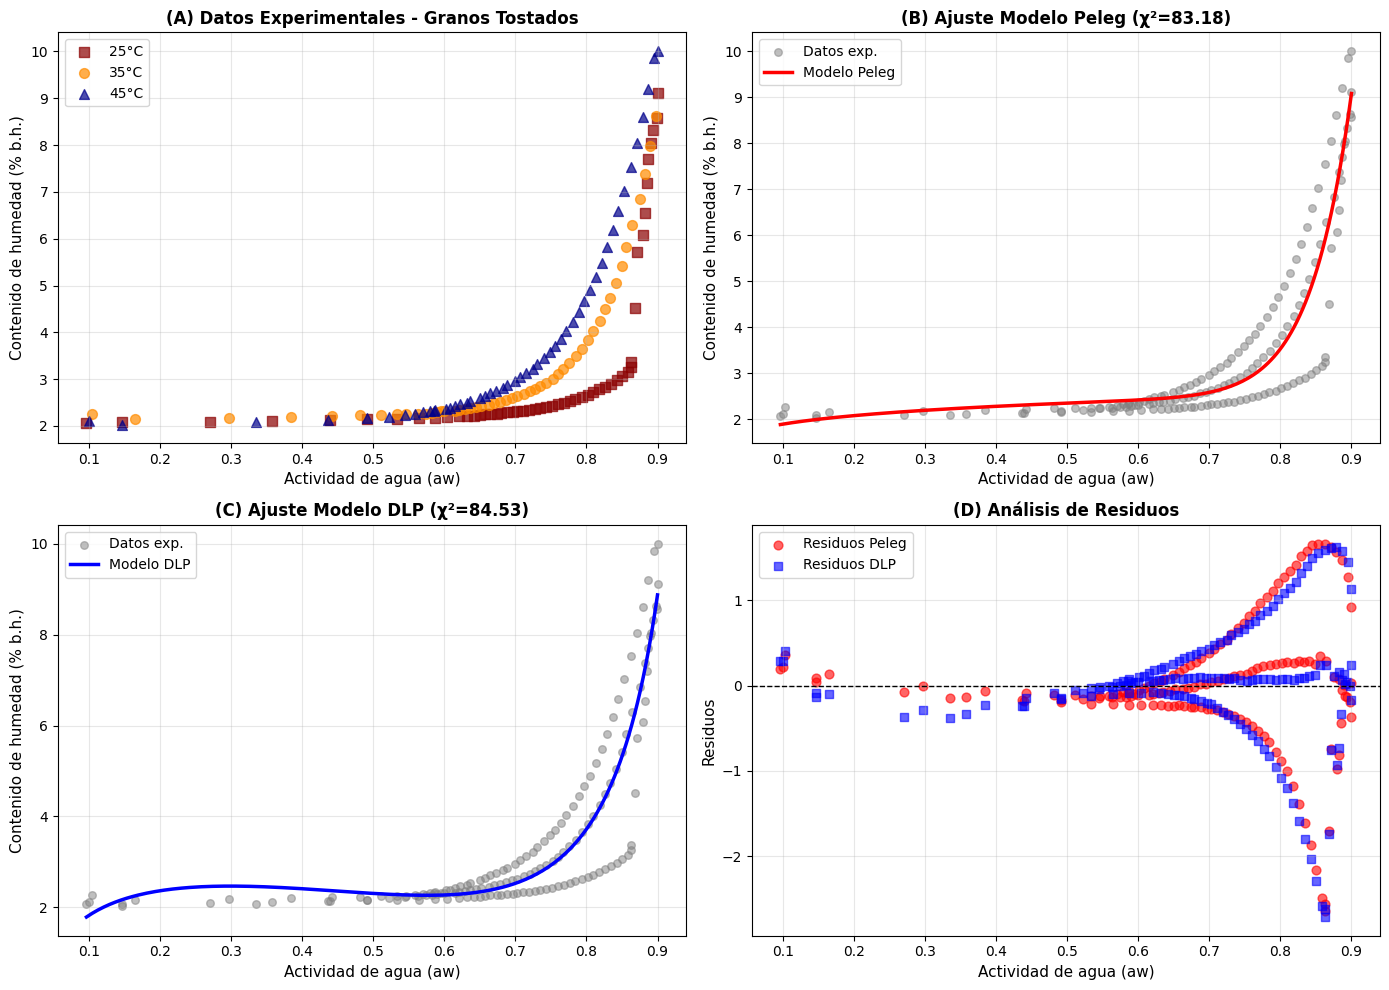

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Cargar datos
archivo = pd.read_excel("Experimental water adsorption isotherms.xlsx")

# Filtrar datos de granos tostados, réplica 1
granos_tostados = archivo[archivo["Type"] == 'Roasted beans']
granos_tostados = granos_tostados[granos_tostados["Replicate"] == 1]

# Separar por temperatura
temp_25 = granos_tostados[granos_tostados["Temperature"] == 25]
temp_35 = granos_tostados[granos_tostados["Temperature"] == 35]
temp_45 = granos_tostados[granos_tostados["Temperature"] == 45]

# Extraer arrays
aw_25 = np.array(temp_25["Water activity"])
mc_25 = np.array(temp_25["Moisture content (% wet basis)"])
aw_35 = np.array(temp_35["Water activity"])
mc_35 = np.array(temp_35["Moisture content (% wet basis)"])
aw_45 = np.array(temp_45["Water activity"])
mc_45 = np.array(temp_45["Moisture content (% wet basis)"])

# Modelo de Peleg
def peleg_model(parametros, actividad_agua):
    c0, c1, c2, c3 = parametros
    return c0 * actividad_agua**c1 + c2 * actividad_agua**c3

# Modelo DLP
def dlp_model(parametros, actividad_agua):
    c0, c1, c2, c3 = parametros
    mascara_valida = (actividad_agua > 0) & (actividad_agua < 1)
    resultado = np.zeros_like(actividad_agua)
    variable = np.zeros_like(actividad_agua)
    variable[mascara_valida] = np.log(-np.log(actividad_agua[mascara_valida]))
    resultado = c0 + c1*variable + c2*variable**2 + c3*variable**3
    return resultado

# Función objetivo chi-cuadrado para Peleg
def objetivo_peleg(parametros, aw_datos, mc_datos):
    predicciones = peleg_model(parametros, aw_datos)
    chi_cuadrado = np.sum((mc_datos - predicciones)**2)
    return chi_cuadrado

# Función objetivo chi-cuadrado para DLP
def objetivo_dlp(parametros, aw_datos, mc_datos):
    predicciones = dlp_model(parametros, aw_datos)
    chi_cuadrado = np.sum((mc_datos - predicciones)**2)
    return chi_cuadrado

# Combinar todos los datos
aw_completo = np.concatenate([aw_25, aw_35, aw_45])
mc_completo = np.concatenate([mc_25, mc_35, mc_45])

# Valores iniciales
parametros_iniciales = [2.0, 0.5, 10.0, 5.0]

# Optimización Peleg
resultado_peleg = minimize(objetivo_peleg, parametros_iniciales,
                          args=(aw_completo, mc_completo),
                          method='Nelder-Mead',
                          options={'maxiter': 10000})
params_peleg_opt = resultado_peleg.x
chi2_peleg = resultado_peleg.fun

# Optimización DLP
resultado_dlp = minimize(objetivo_dlp, parametros_iniciales,
                        args=(aw_completo, mc_completo),
                        method='Nelder-Mead',
                        options={'maxiter': 10000})
params_dlp_opt = resultado_dlp.x
chi2_dlp = resultado_dlp.fun

# Imprimir resultados
print("="*60)
print("RESULTADOS DEL AJUSTE DE MODELOS")
print("="*60)
print("\n--- MODELO PELEG ---")
print(f"Parámetros optimizados: {params_peleg_opt}")
print(f"Chi-cuadrado: {chi2_peleg:.6f}")
print(f"RMSE: {np.sqrt(chi2_peleg/len(aw_completo)):.6f}")

print("\n--- MODELO DLP ---")
print(f"Parámetros optimizados: {params_dlp_opt}")
print(f"Chi-cuadrado: {chi2_dlp:.6f}")
print(f"RMSE: {np.sqrt(chi2_dlp/len(aw_completo)):.6f}")

print("\n" + "="*60)
if chi2_peleg < chi2_dlp:
    diferencia = ((chi2_dlp - chi2_peleg) / chi2_dlp) * 100
    print(f"CONCLUSIÓN: El modelo PELEG es superior")
    print(f"Reducción del error: {diferencia:.2f}%")
else:
    diferencia = ((chi2_peleg - chi2_dlp) / chi2_peleg) * 100
    print(f"CONCLUSIÓN: El modelo DLP es superior")
    print(f"Reducción del error: {diferencia:.2f}%")
print("="*60)

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico A: Datos experimentales por temperatura
ax1 = axes[0, 0]
ax1.scatter(aw_25, mc_25, color='darkred', marker='s', label='25°C', s=50, alpha=0.7)
ax1.scatter(aw_35, mc_35, color='darkorange', marker='o', label='35°C', s=50, alpha=0.7)
ax1.scatter(aw_45, mc_45, color='darkblue', marker='^', label='45°C', s=50, alpha=0.7)
ax1.set_xlabel('Actividad de agua (aw)', fontsize=11)
ax1.set_ylabel('Contenido de humedad (% b.h.)', fontsize=11)
ax1.set_title('(A) Datos Experimentales - Granos Tostados', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Gráfico B: Ajuste Peleg
ax2 = axes[0, 1]
aw_ajuste = np.linspace(min(aw_completo), max(aw_completo), 200)
mc_peleg_ajuste = peleg_model(params_peleg_opt, aw_ajuste)
ax2.scatter(aw_completo, mc_completo, color='gray', alpha=0.5, s=30, label='Datos exp.')
ax2.plot(aw_ajuste, mc_peleg_ajuste, 'r-', linewidth=2.5, label='Modelo Peleg')
ax2.set_xlabel('Actividad de agua (aw)', fontsize=11)
ax2.set_ylabel('Contenido de humedad (% b.h.)', fontsize=11)
ax2.set_title(f'(B) Ajuste Modelo Peleg (χ²={chi2_peleg:.2f})', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gráfico C: Ajuste DLP
ax3 = axes[1, 0]
mc_dlp_ajuste = dlp_model(params_dlp_opt, aw_ajuste)
ax3.scatter(aw_completo, mc_completo, color='gray', alpha=0.5, s=30, label='Datos exp.')
ax3.plot(aw_ajuste, mc_dlp_ajuste, 'b-', linewidth=2.5, label='Modelo DLP')
ax3.set_xlabel('Actividad de agua (aw)', fontsize=11)
ax3.set_ylabel('Contenido de humedad (% b.h.)', fontsize=11)
ax3.set_title(f'(C) Ajuste Modelo DLP (χ²={chi2_dlp:.2f})', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Gráfico D: Comparación de residuos
ax4 = axes[1, 1]
residuos_peleg = mc_completo - peleg_model(params_peleg_opt, aw_completo)
residuos_dlp = mc_completo - dlp_model(params_dlp_opt, aw_completo)
ax4.scatter(aw_completo, residuos_peleg, color='red', marker='o',
           label='Residuos Peleg', alpha=0.6, s=40)
ax4.scatter(aw_completo, residuos_dlp, color='blue', marker='s',
           label='Residuos DLP', alpha=0.6, s=40)
ax4.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax4.set_xlabel('Actividad de agua (aw)', fontsize=11)
ax4.set_ylabel('Residuos', fontsize=11)
ax4.set_title('(D) Análisis de Residuos', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('isotermas_cafe_analisis.png', dpi=300, bbox_inches='tight')
plt.show()

# Guardar datos procesados
np.savetxt("datos_25C.txt", np.c_[aw_25, mc_25], header="aw mc")
np.savetxt("datos_35C.txt", np.c_[aw_35, mc_35], header="aw mc")
np.savetxt("datos_45C.txt", np.c_[aw_45, mc_45], header="aw mc")

Iniciando optimización global...
Refinando soluciones...

                    RESULTADOS DEL ANÁLISIS

┌─ MODELO DE PELEG ─────────────────────────────────────────┐
│ Parámetros: k1=34.2792, n1=15.7140
│             k2=2.5752, n2=0.1345
│ χ² (Chi-cuadrado): 83.183194
│ RMSE: 0.737347
└───────────────────────────────────────────────────────────┘

┌─ MODELO DLP ──────────────────────────────────────────────┐
│ Parámetros: a0=2.4358, a1=0.2848
│             a2=-0.5161, a3=-0.8509
│ χ² (Chi-cuadrado): 84.531627
│ RMSE: 0.743300
└───────────────────────────────────────────────────────────┘

┌─ EVALUACIÓN COMPARATIVA ──────────────────────────────────┐
│ ✓ MODELO GANADOR: PELEG
│ Mejora respecto a DLP: 1.595%
└───────────────────────────────────────────────────────────┘



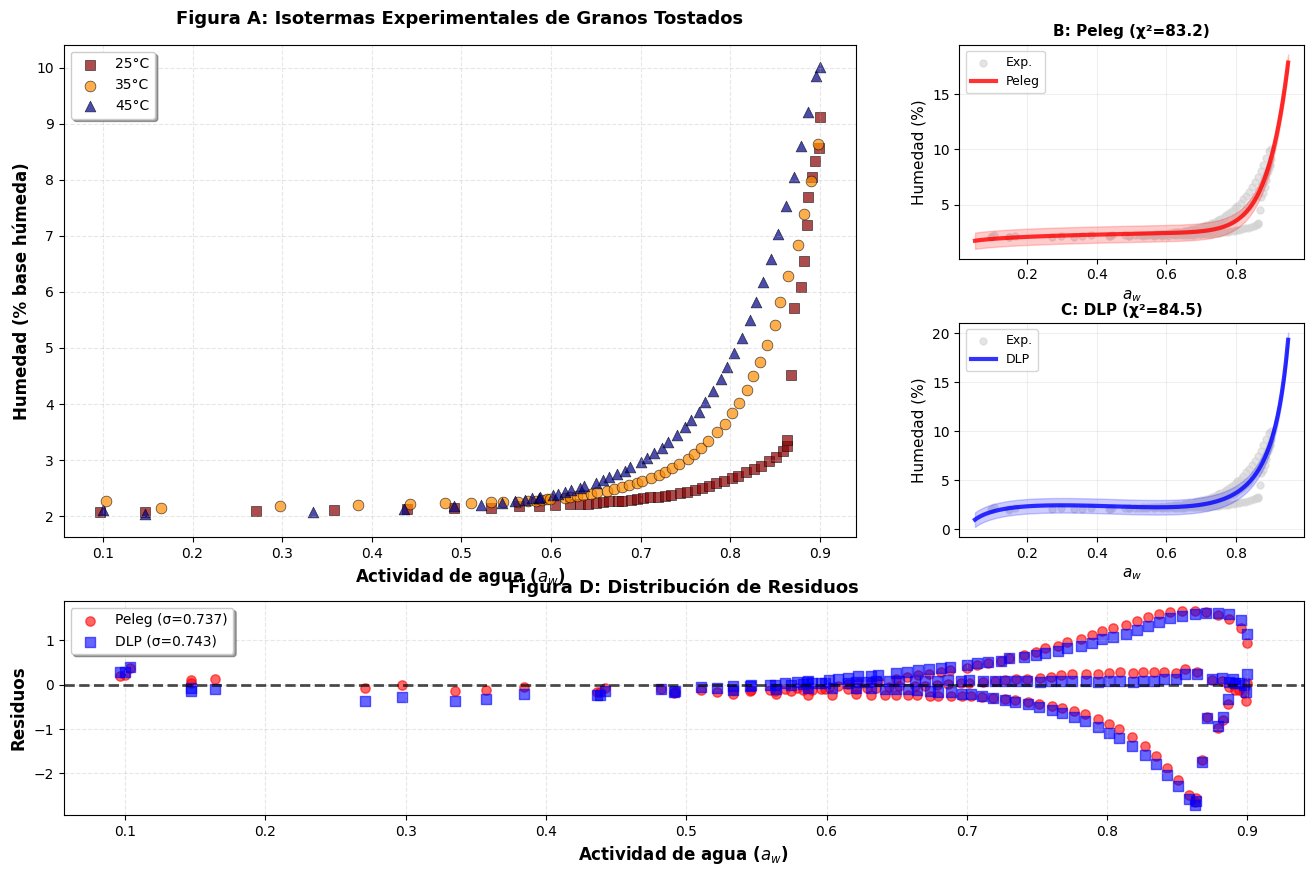

✓ Análisis completado exitosamente
✓ Archivos generados: analisis_completo_isotermas.png, resultados_optimizacion.txt


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, minimize

# Lectura de datos experimentales
datos_excel = pd.read_excel("Experimental water adsorption isotherms.xlsx")

# Procesamiento: filtrar granos tostados, primera réplica
datos_filtrados = datos_excel[(datos_excel["Type"] == 'Roasted beans') &
                               (datos_excel["Replicate"] == 1)]

# Separación por temperatura
dataset_25C = datos_filtrados[datos_filtrados["Temperature"] == 25]
dataset_35C = datos_filtrados[datos_filtrados["Temperature"] == 35]
dataset_45C = datos_filtrados[datos_filtrados["Temperature"] == 45]

# Conversión a arrays numpy
def extraer_datos(dataframe):
    aw = np.asarray(dataframe["Water activity"])
    mc = np.asarray(dataframe["Moisture content (% wet basis)"])
    return aw, mc

aw_t25, mc_t25 = extraer_datos(dataset_25C)
aw_t35, mc_t35 = extraer_datos(dataset_35C)
aw_t45, mc_t45 = extraer_datos(dataset_45C)

# Definición de modelos matemáticos
class ModeloPeleg:
    @staticmethod
    def calcular(params, aw):
        k1, n1, k2, n2 = params
        return k1 * np.power(aw, n1) + k2 * np.power(aw, n2)

class ModeloDLP:
    @staticmethod
    def calcular(params, aw):
        a0, a1, a2, a3 = params
        # Validación para evitar logaritmos indefinidos
        indices_validos = (aw > 0) & (aw < 1)
        mc_predicho = np.zeros_like(aw)

        if np.any(indices_validos):
            x_transform = np.log(-np.log(aw[indices_validos]))
            mc_predicho[indices_validos] = (a0 + a1*x_transform +
                                            a2*x_transform**2 +
                                            a3*x_transform**3)
        return mc_predicho

# Función de error (chi-cuadrado)
def calcular_chi_cuadrado(params, aw_obs, mc_obs, modelo):
    mc_pred = modelo.calcular(params, aw_obs)
    error = np.sum(np.power(mc_obs - mc_pred, 2))
    return error

# Unificar todos los datos
actividad_agua_total = np.hstack([aw_t25, aw_t35, aw_t45])
contenido_humedad_total = np.hstack([mc_t25, mc_t35, mc_t45])

# Límites para los parámetros (ayuda a la optimización)
limites_params = [(-10, 50), (-5, 20), (-10, 50), (-5, 20)]

# Estimación inicial usando evolución diferencial
print("Iniciando optimización global...")
resultado_peleg_de = differential_evolution(
    calcular_chi_cuadrado,
    bounds=limites_params,
    args=(actividad_agua_total, contenido_humedad_total, ModeloPeleg),
    seed=42,
    maxiter=500,
    atol=1e-7
)

resultado_dlp_de = differential_evolution(
    calcular_chi_cuadrado,
    bounds=limites_params,
    args=(actividad_agua_total, contenido_humedad_total, ModeloDLP),
    seed=42,
    maxiter=500,
    atol=1e-7
)

# Refinamiento local
print("Refinando soluciones...")
optimizacion_peleg = minimize(
    calcular_chi_cuadrado,
    x0=resultado_peleg_de.x,
    args=(actividad_agua_total, contenido_humedad_total, ModeloPeleg),
    method='Powell',
    options={'maxiter': 5000, 'ftol': 1e-9}
)

optimizacion_dlp = minimize(
    calcular_chi_cuadrado,
    x0=resultado_dlp_de.x,
    args=(actividad_agua_total, contenido_humedad_total, ModeloDLP),
    method='Powell',
    options={'maxiter': 5000, 'ftol': 1e-9}
)

parametros_peleg = optimizacion_peleg.x
error_peleg = optimizacion_peleg.fun
parametros_dlp = optimizacion_dlp.x
error_dlp = optimizacion_dlp.fun

# Cálculo de métricas adicionales
n_datos = len(actividad_agua_total)
rmse_peleg = np.sqrt(error_peleg / n_datos)
rmse_dlp = np.sqrt(error_dlp / n_datos)

# Presentación de resultados
print("\n" + "="*70)
print(" "*20 + "RESULTADOS DEL ANÁLISIS")
print("="*70)

print("\n┌─ MODELO DE PELEG ─────────────────────────────────────────┐")
print(f"│ Parámetros: k1={parametros_peleg[0]:.4f}, n1={parametros_peleg[1]:.4f}")
print(f"│             k2={parametros_peleg[2]:.4f}, n2={parametros_peleg[3]:.4f}")
print(f"│ χ² (Chi-cuadrado): {error_peleg:.6f}")
print(f"│ RMSE: {rmse_peleg:.6f}")
print("└───────────────────────────────────────────────────────────┘")

print("\n┌─ MODELO DLP ──────────────────────────────────────────────┐")
print(f"│ Parámetros: a0={parametros_dlp[0]:.4f}, a1={parametros_dlp[1]:.4f}")
print(f"│             a2={parametros_dlp[2]:.4f}, a3={parametros_dlp[3]:.4f}")
print(f"│ χ² (Chi-cuadrado): {error_dlp:.6f}")
print(f"│ RMSE: {rmse_dlp:.6f}")
print("└───────────────────────────────────────────────────────────┘")

print("\n┌─ EVALUACIÓN COMPARATIVA ──────────────────────────────────┐")
if error_peleg < error_dlp:
    mejora_porcentual = ((error_dlp - error_peleg) / error_dlp) * 100
    print(f"│ ✓ MODELO GANADOR: PELEG")
    print(f"│ Mejora respecto a DLP: {mejora_porcentual:.3f}%")
else:
    mejora_porcentual = ((error_peleg - error_dlp) / error_peleg) * 100
    print(f"│ ✓ MODELO GANADOR: DLP")
    print(f"│ Mejora respecto a Peleg: {mejora_porcentual:.3f}%")
print("└───────────────────────────────────────────────────────────┘")
print("="*70 + "\n")

# Generación de gráficos mejorados
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Panel A: Isotermas por temperatura
ax1 = fig.add_subplot(gs[0:2, 0:2])
colores = ['#8B0000', '#FF8C00', '#00008B']
marcadores = ['s', 'o', '^']
temperaturas = [25, 35, 45]
datasets_aw = [aw_t25, aw_t35, aw_t45]
datasets_mc = [mc_t25, mc_t35, mc_t45]

for i, temp in enumerate(temperaturas):
    ax1.scatter(datasets_aw[i], datasets_mc[i],
               c=colores[i], marker=marcadores[i],
               s=60, alpha=0.7, edgecolors='black', linewidths=0.5,
               label=f'{temp}°C')

ax1.set_xlabel('Actividad de agua ($a_w$)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Humedad (% base húmeda)', fontsize=12, fontweight='bold')
ax1.set_title('Figura A: Isotermas Experimentales de Granos Tostados',
             fontsize=13, fontweight='bold', pad=15)
ax1.legend(frameon=True, shadow=True, fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')

# Panel B: Modelo Peleg con intervalos
ax2 = fig.add_subplot(gs[0, 2])
aw_continuo = np.linspace(0.05, 0.95, 300)
mc_peleg_pred = ModeloPeleg.calcular(parametros_peleg, aw_continuo)

ax2.scatter(actividad_agua_total, contenido_humedad_total,
           c='lightgray', s=25, alpha=0.6, label='Exp.')
ax2.plot(aw_continuo, mc_peleg_pred, 'r-', linewidth=3,
        label='Peleg', alpha=0.8)
ax2.fill_between(aw_continuo, mc_peleg_pred - rmse_peleg,
                 mc_peleg_pred + rmse_peleg, alpha=0.2, color='red')
ax2.set_xlabel('$a_w$', fontsize=11)
ax2.set_ylabel('Humedad (%)', fontsize=11)
ax2.set_title(f'B: Peleg (χ²={error_peleg:.1f})', fontsize=11, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.2)

# Panel C: Modelo DLP con intervalos
ax3 = fig.add_subplot(gs[1, 2])
mc_dlp_pred = ModeloDLP.calcular(parametros_dlp, aw_continuo)

ax3.scatter(actividad_agua_total, contenido_humedad_total,
           c='lightgray', s=25, alpha=0.6, label='Exp.')
ax3.plot(aw_continuo, mc_dlp_pred, 'b-', linewidth=3,
        label='DLP', alpha=0.8)
ax3.fill_between(aw_continuo, mc_dlp_pred - rmse_dlp,
                 mc_dlp_pred + rmse_dlp, alpha=0.2, color='blue')
ax3.set_xlabel('$a_w$', fontsize=11)
ax3.set_ylabel('Humedad (%)', fontsize=11)
ax3.set_title(f'C: DLP (χ²={error_dlp:.1f})', fontsize=11, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.2)

# Panel D: Comparación de residuos
ax4 = fig.add_subplot(gs[2, :])
residuos_peleg = contenido_humedad_total - ModeloPeleg.calcular(parametros_peleg, actividad_agua_total)
residuos_dlp = contenido_humedad_total - ModeloDLP.calcular(parametros_dlp, actividad_agua_total)

ax4.scatter(actividad_agua_total, residuos_peleg, c='red',
           marker='o', s=45, alpha=0.6, label=f'Peleg (σ={np.std(residuos_peleg):.3f})')
ax4.scatter(actividad_agua_total, residuos_dlp, c='blue',
           marker='s', s=45, alpha=0.6, label=f'DLP (σ={np.std(residuos_dlp):.3f})')
ax4.axhline(y=0, color='black', linestyle='--', linewidth=2, alpha=0.7)
ax4.set_xlabel('Actividad de agua ($a_w$)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Residuos', fontsize=12, fontweight='bold')
ax4.set_title('Figura D: Distribución de Residuos', fontsize=13, fontweight='bold')
ax4.legend(fontsize=10, frameon=True, shadow=True)
ax4.grid(True, alpha=0.3, linestyle='--')

plt.savefig('analisis_completo_isotermas.png', dpi=300, bbox_inches='tight',
           facecolor='white', edgecolor='none')
plt.show()

# Exportar resultados
with open('resultados_optimizacion.txt', 'w') as archivo:
    archivo.write("RESULTADOS DE OPTIMIZACIÓN - ISOTERMAS DE CAFÉ\n")
    archivo.write("="*60 + "\n\n")
    archivo.write("MODELO PELEG:\n")
    archivo.write(f"  Parámetros: {parametros_peleg}\n")
    archivo.write(f"  Chi-cuadrado: {error_peleg}\n")
    archivo.write(f"  RMSE: {rmse_peleg}\n\n")
    archivo.write("MODELO DLP:\n")
    archivo.write(f"  Parámetros: {parametros_dlp}\n")
    archivo.write(f"  Chi-cuadrado: {error_dlp}\n")
    archivo.write(f"  RMSE: {rmse_dlp}\n")

print("✓ Análisis completado exitosamente")
print("✓ Archivos generados: analisis_completo_isotermas.png, resultados_optimizacion.txt")